# Install Packages, Device

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import ssl
import certifi
ssl._create_default_https_context = ssl._create_unverified_context

In [37]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

Using device = cuda


# VGG Model and Layers

In [38]:
# Load VGG19 model
model = models.vgg19(pretrained=True).features
print(model)

C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Parameters

## Layers

In [39]:
# #1 standard
# CN=1
# conv_layers = ['0', '5', '10', '19', '28']

In [40]:
# #2 deep and medium layers
# CN=2
# conv_layers = ['0', '5', '19', '21', '23', '25', '28', '30', '32', '34']

In [41]:
#3 deep layers
CN=3
conv_layers = ['19', '21', '23', '25', '28', '30', '32', '34']

In [42]:
# #4 low layers
# CN =4
# conv_layers = ['0', '2', '5', '7', '10']

## Images

In [43]:
content_image = "miley_cyrus"
style_image = "zaha-texture"

# Model

In [44]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        self.chosen_features = conv_layers
        self.model = models.vgg19(pretrained=True).features[:29]
        
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            if str(layer_num) in self.chosen_features:
                features.append(x)
                
        return features

In [208]:
model = VGG().to(device).eval()
print(model)

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [209]:
def load_image(image_name, image_size=256):
    loader = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    
    image = Image.open(image_name)
    image = image.convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [210]:
image_size = 256
content = load_image("final_project_images/content_images/" + content_image + ".png", image_size)
style = load_image("final_project_images/style_images/" + style_image + ".png", image_size)

In [211]:
type(content)

torch.Tensor

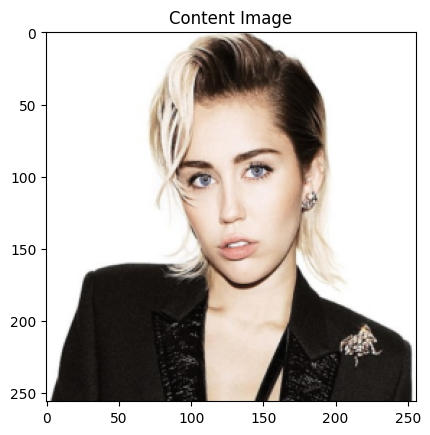

In [212]:
# display the images
unloader = transforms.ToPILImage()
import matplotlib.pyplot as plt
    
plt.ion()
    
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(content, title='Content Image')

In [213]:
generated = content.clone().requires_grad_(True)

# Hyperparameters

In [214]:
total_steps = 3000
learning_rate = 0.001
alpha = 1 # content loss
beta = 0.01 # style loss

In [215]:
# #a
# alpha = .1 # content loss
# beta = 1 # style loss

In [216]:
optimizer = optim.Adam([generated], lr=learning_rate, betas=[0.5, 0.999])

In [217]:
for step in range(total_steps):
    generated_features = model(generated)
    content_features = model(content)
    style_features = model(style)
    
    style_loss =0
    content_loss = 0
    
    for gen_feature, content_feature, style_feature in zip(generated_features,content_features, style_features):
        batch_size, channel, height, width = gen_feature.shape
        
        content_loss += torch.mean((gen_feature - content_feature)**2)
        
        # Compute Gram Matrix
        G_gen = gen_feature.view(channel, height*width).mm(gen_feature.view(channel, height*width).t())
        G_style = style_feature.view(channel, height*width).mm(style_feature.view(channel, height*width).t())
        
        style_loss += torch.mean((G_gen - G_style)**2)
        
    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print(total_loss)
        image_name = "image_gens/" + content_image + "_arch/" + style_image + "_" + str(CN) + "_" + str(step) + ".png"
        save_image(generated, image_name)
    

tensor(430493.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72931.2891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41408.3828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28831.6035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21455.5742, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16746.5449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13499.4316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11160.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9455.5205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8135.9819, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7068.4668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6193.6577, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5473.7026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4866.3662, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4342.8223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3886.3335, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3488.4604, device='cuda:0', grad_fn=<Add

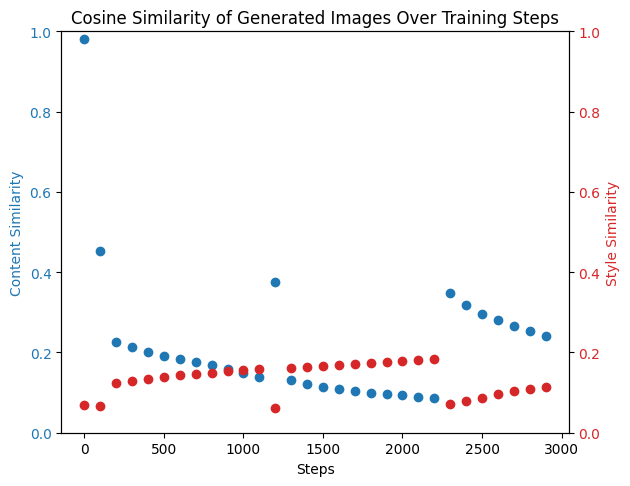

In [47]:
 %run sim_score_comparison-Copy1.py

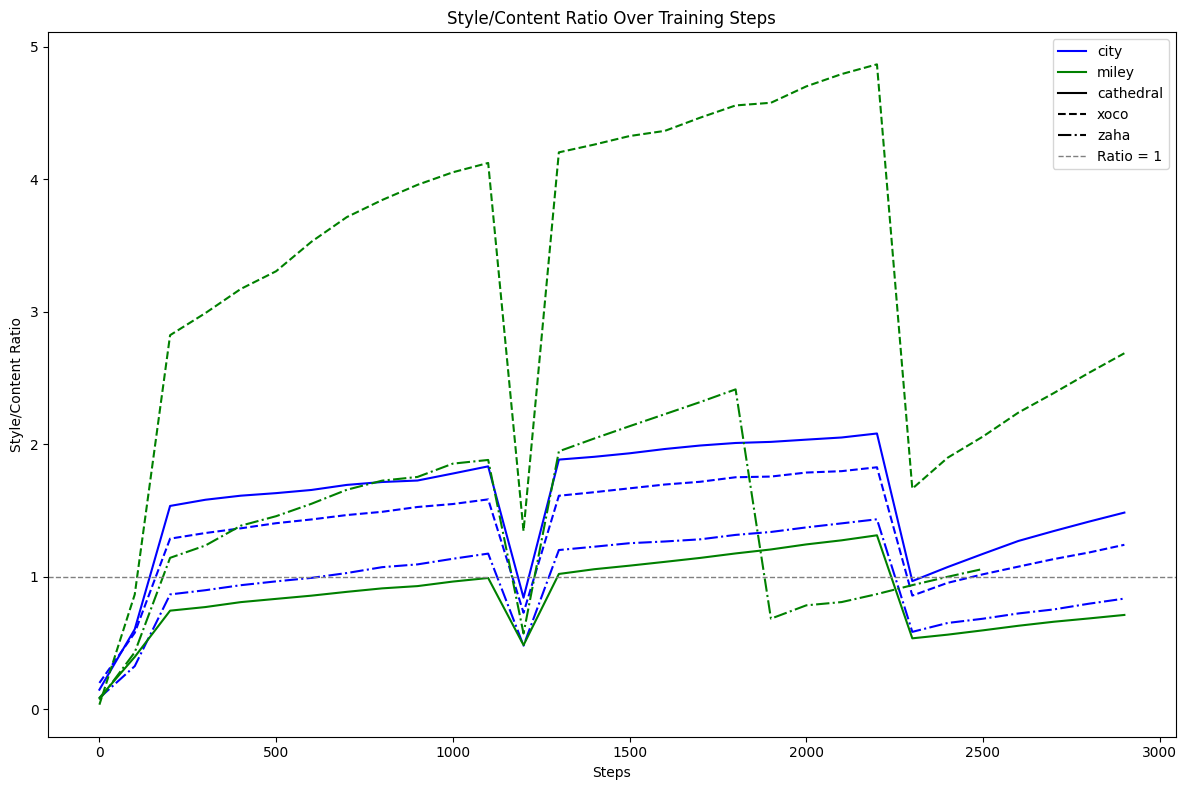

In [56]:
 %run plot_similarity_scores.py